#### Parte 0 - Funcoes auxiliares para o projeto

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
def linearSolve(a, b):
    '''
        Resolve um sistema linear utilizando o metodo de
        diagonalizacao da matriz (fatoracao de Gauss) seguido da
        resolucao do sistema triangular superior.
        
        IMPORTANTE (1): Idealmente, trabalhe com floats (coloca um '.' dps do numero inteiro.)
        IMPORTANTE(2): a e b sao arrays, nao listas.
    '''
    
    # Diagonaliza a matriz a
    for i in range(a.shape[0]-1):
        max = i+ np.argmax(np.absolute(a[i:, i]))
        
        a[[i,max]] = a[[max,i]] # Troca linhas da array (magic!)
        b[[i,max]] = b[[max,i]]

        for j in range(i+1, a.shape[0]):
            m = a[j,i]/(float)(a[i,i])
            a[j] = a[j] - (m*a[i]) # Usar -= da um warning (nao sei o porque)
            b[j] = b[j] - (m*b[i])
      
    x = np.empty(b.shape)
    for i in np.arange(a.shape[0]-1, -1, -1):
        x[i] = b[i]
        for j in np.arange(a.shape[0]-1, i, -1):
            x[i] -= (a[i, j] * x[j])
        x[i] /= (float)(a[i,i])
    return x

In [3]:
# Teste da funcao linearsolve().
# Faca mais testes pra ver se encontra bugs 
a = np.array([[.3e33,1., .5e4], [1.,2., .5e4],[3.5, 4., .5e-4]])
b = np.array([9. ,8., .1])

x = linearSolve(a, b)
print x
print "testando solucao..."
if np.allclose(np.dot(a, x), b):
    print "Sistema resolvido corretamente."
else:
    print "Resposta esperada:", np.linalg.solve(a, b)

[  3.41666660e-33   2.49999801e-02   1.59000001e-03]
testando solucao...
Sistema resolvido corretamente.


# Parte 1 - Cantareira

Nessa parte, analizaremos dados do nível de água da usina Cantareira entre os anos de 2003 e agosto de 2015. 

O proposto é utilizar métodos numéricos para ajustar os dados a uma função apropriada.

In [4]:
# Cria estrutura para armazenar datas e niveis da usina cantareira
cantareira = {"datas": [], "dia": [], "niveis": []}
datas = cantareira["datas"]
dia = cantareira["dia"]
niveis = cantareira["niveis"]

In [5]:
#Formata os dados lidos do arquivo como duas listas
with open('cantareira.txt', 'r') as file:
    i = 1
    for line in file:
        atual = line.split()
        datas.append(int(atual[0]))
        dia.append(i)
        niveis.append(float(atual[1]))
        i+=1

In [6]:
datasArray = np.array(datas, dtype='float64')
diaArray = np.array(dia, dtype='float64')
niveisArray = np.array(niveis, dtype='float64')

In [7]:
print "datas\t\t","dia\t", "niveis"
for i in range(len(datas)):
    print datas[i],"\t",dia[i], "\t", niveis[i]

datas		dia	niveis
20030101 	1 	42.5
20030102 	2 	42.3
20030103 	3 	42.3
20030104 	4 	42.3
20030105 	5 	42.4
20030106 	6 	42.4
20030107 	7 	42.5
20030108 	8 	42.5
20030109 	9 	42.6
20030110 	10 	42.3
20030111 	11 	42.4
20030112 	12 	42.6
20030113 	13 	43.0
20030114 	14 	42.9
20030115 	15 	42.8
20030116 	16 	42.8
20030117 	17 	43.3
20030118 	18 	44.6
20030119 	19 	45.3
20030120 	20 	46.1
20030121 	21 	46.7
20030122 	22 	48.1
20030123 	23 	49.2
20030124 	24 	50.1
20030125 	25 	51.1
20030126 	26 	52.1
20030127 	27 	53.3
20030128 	28 	54.4
20030129 	29 	56.0
20030130 	30 	57.5
20030131 	31 	59.1
20030201 	32 	60.4
20030202 	33 	61.1
20030203 	34 	61.5
20030204 	35 	61.9
20030205 	36 	62.1
20030206 	37 	62.6
20030207 	38 	62.9
20030208 	39 	63.0
20030209 	40 	63.2
20030210 	41 	63.3
20030211 	42 	63.4
20030212 	43 	63.4
20030213 	44 	63.2
20030214 	45 	63.6
20030215 	46 	63.6
20030216 	47 	63.8
20030217 	48 	63.8
20030218 	49 	64.7
20030219 	50 	65.0
20030220 	51 	65.2
20030221 	52 	65.5
200

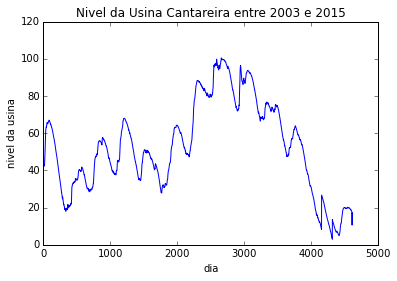

In [8]:
plt.plot(dia, niveis, 'b-')
plt.title("Nivel da Usina Cantareira entre 2003 e 2015")
plt.ylabel('nivel da usina')
plt.xlabel("dia")
plt.show()

## Aproximações para a a tabela por mínimos quadrados

In [9]:
def residuoMMQ(f, x, y):
    '''
        Calcula o residuo (soma dos quadrados dos erros) da aprox f de y nos pontos x.
    '''
    
    soma = 0
    for xk, yk in zip(x,y):
        soma += pow(f(xk) - yk, 2)
    return soma

### Função linear

Aproximaremos a tabela acima por uma função no modelo
$$f(x) = a \cdot g_1(x) + b \cdot g_2(x),$$
com $g_1(x) = x$ e $g_2(x) = 1$.
Para descobrir os coeficientes, temos que
$$L(a, b) = \sum\limits_{k=1}^m (f(x_k) - y_k)^2$$
tem que ser mínima. para isso, $\frac{\partial L(a)}{\partial a} = 0$ e $\frac{\partial L(b)}{\partial b} = 0$. Assim, teremos que resolver um sistema de equações no formato:

$$\sum\limits_{k=1}^m x_k^2 \cdot a + \sum\limits_{k=1}^m x_k \cdot b = \sum\limits_{k=1}^m (x_k \cdot y_k) $$
$$\sum\limits_{k=1}^m x_k \cdot a + \sum\limits_{k=1}^m 1 \cdot b = \sum\limits_{k=1}^m (1 \cdot y_k) $$

In [10]:
def linearMMQ(x, y):
    '''
        Aproxima pontos dados numa funcao linear pelo metodo dos minimos quadrados.
    '''
    # Ajustando os coeficientes das matrizes A e B
    somaX = np.sum(x)
    somaQuadradoX = np.sum(np.square(x))
    somaY = np.sum(y)
    somaXY = np.sum(np.multiply(x, y))
    num = len(y)

    a = np.array([[somaQuadradoX, somaX],
                  [somaX, num]])
    b = np.array([somaXY, somaY])
    print "Resolvendo o sistema linear A * c = B:"
    print "A =", a
    print "B =", b
    
    c = linearSolve(a, b)
    
    print "testando solucao..."
    if np.allclose(np.dot(a, c), b):
        print "Sistema resolvido corretamente."
    else:
        print "Resposta esperada:", np.linalg.solve(a, b)
    return c

In [11]:
c1 = linearMMQ(diaArray, niveisArray)

Resolvendo o sistema linear A * c = B:
A = [[  3.28170435e+10   1.06606530e+07]
 [  1.06606530e+07   4.61700000e+03]]
B = [  5.60840466e+08   2.44031300e+05]
testando solucao...
Sistema resolvido corretamente.


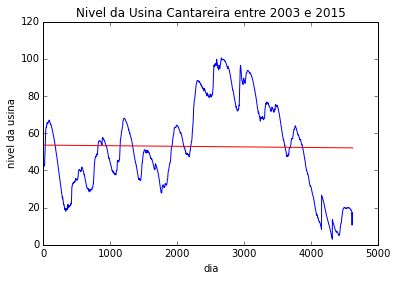

O residuo encontrado na aproximacao foi: 2736075.73591


In [12]:
aproxLin = lambda x: c1[0]*x + c1[1] #funcao linear encontrada

linearY = np.vectorize(aproxLin)(dia)

plt.plot(dia, niveis, 'b-')
plt.plot(dia, linearY, 'r-')
plt.title("Nivel da Usina Cantareira entre 2003 e 2015")
plt.ylabel('nivel da usina')
plt.xlabel("dia")
plt.show()
print "O residuo encontrado na aproximacao foi:",residuoMMQ(aproxLin, dia, niveis)

Note que a aproximação considerada não foi satisfatória, já que não se pode avaliar bem o comportamento da usina com base na reta encontrada, e o resíduo foi muito grande.

### Função de 4o grau

Para fazer a aproximação, seguimos o mesmo processo da etapa linear, mas considerando o modelo


$$f(x) = a \cdot g_1(x) + b \cdot g_2(x) + c \cdot g_3(x) + d \cdot g_4(x) + e \cdot g_5(x),$$


com $g_1(x) = x^4$, $g_2(x) = x^3$, $g_3(x) = x^2$, $g_4(x) = x$ e $g_5(x) = 1$.
Dessa forma, chegamos no sistema:


$$\sum\limits_{k=1}^m x_k^8 \cdot a + \sum\limits_{k=1}^m x_k^7 \cdot b + \sum\limits_{k=1}^m x_k^6 \cdot c + \sum\limits_{k=1}^m x_k^5 \cdot d + \sum\limits_{k=1}^m x_k^4 \cdot e= \sum\limits_{k=1}^m (x_k^4 \cdot y_k) $$
$$\sum\limits_{k=1}^m x_k^7 \cdot a + \sum\limits_{k=1}^m x_k^6 \cdot b + \sum\limits_{k=1}^m x_k^5 \cdot c + \sum\limits_{k=1}^m x_k^4 \cdot d + \sum\limits_{k=1}^m x_k^3 \cdot e= \sum\limits_{k=1}^m (x_k^3 \cdot y_k) $$
$$\sum\limits_{k=1}^m x_k^6 \cdot a + \sum\limits_{k=1}^m x_k^5 \cdot b + \sum\limits_{k=1}^m x_k^4 \cdot c + \sum\limits_{k=1}^m x_k^3 \cdot d + \sum\limits_{k=1}^m x_k^2 \cdot e= \sum\limits_{k=1}^m (x_k^2 \cdot y_k) $$
$$\sum\limits_{k=1}^m x_k^5 \cdot a + \sum\limits_{k=1}^m x_k^4 \cdot b + \sum\limits_{k=1}^m x_k^3 \cdot c + \sum\limits_{k=1}^m x_k^2 \cdot d + \sum\limits_{k=1}^m x_k \cdot e= \sum\limits_{k=1}^m (x_k \cdot y_k) $$
$$\sum\limits_{k=1}^m x_k^4 \cdot a + \sum\limits_{k=1}^m x_k^3 \cdot b + \sum\limits_{k=1}^m x_k^2 \cdot c + \sum\limits_{k=1}^m x_k \cdot d + \sum\limits_{k=1}^m 1 \cdot e= \sum\limits_{k=1}^m (1 \cdot y_k) $$

In [13]:
def quartoGrauMMQ(x, y):
    '''
        Aproxima pontos dados numa funcao polinomial de 4o grau pelo metodo dos minimos quadrados.
    '''
    somaPotX = []
    for i in range(9):
        sum = 0 #Pode ser reduzida para somaPotX.append(np.sum(x**i)) se nao houver overflow
        for xk in x:
            sum += pow(xk, i)
        somaPotX.append(sum)
        
    somaPotXY = []
    for i in range(5): 
        soma = 0 #Pode ser reduzida para somaPotXY.append(np.sum(np.multiply(x**i, y))) se nao houver overflow
        for xk, yk in zip(x,y):
            soma += (pow(xk, i)*yk)
        somaPotXY.append(soma)
    
    # Ajustando os coeficientes das matrizes A e B
    a = np.array(
        [[somaPotX[8], somaPotX[7], somaPotX[6], somaPotX[5], somaPotX[4]],
         [somaPotX[7], somaPotX[6], somaPotX[5], somaPotX[4], somaPotX[3]],
         [somaPotX[6], somaPotX[5], somaPotX[4], somaPotX[3], somaPotX[2]],
         [somaPotX[5], somaPotX[4], somaPotX[3], somaPotX[2], somaPotX[1]],
         [somaPotX[4], somaPotX[3], somaPotX[2], somaPotX[1], somaPotX[0]]])
         
    b = np.array(somaPotXY[::-1]) #B eh a array somaPotXY de baixo pra cima
    
    print "Resolvendo o sistema linear A * c = B:"
    print "A =", a
    print "B =", b
    
    c = linearSolve(a, b)
    
    #testando a solucao
    print "testando solucao..."
    if np.allclose(np.dot(a, c), b):
        print "Sistema resolvido corretamente."
    else:
        print "Resposta esperada:", np.linalg.solve(a, b)
    return c

In [14]:
c4 = quartoGrauMMQ(diaArray, niveisArray)
print c4

Resolvendo o sistema linear A * c = B:
A = [[  1.06027755e+32   2.58324263e+28   6.39367053e+24   1.61543746e+21
    4.19821329e+17]
 [  2.58324263e+28   6.39367053e+24   1.61543746e+21   4.19821329e+17
    1.13649522e+14]
 [  6.39367053e+24   1.61543746e+21   4.19821329e+17   1.13649522e+14
    3.28170435e+10]
 [  1.61543746e+21   4.19821329e+17   1.13649522e+14   3.28170435e+10
    1.06606530e+07]
 [  4.19821329e+17   1.13649522e+14   3.28170435e+10   1.06606530e+07
    4.61700000e+03]]
B = [  1.67029416e+19   5.02689483e+15   1.60327035e+12   5.60840466e+08
   2.44031300e+05]
testando solucao...
Sistema resolvido corretamente.
[  1.81945642e-12  -2.33375355e-08   8.49240250e-05  -8.79321350e-02
   6.12828699e+01]


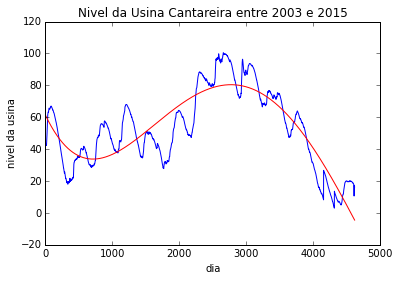

O residuo encontrado na aproximacao foi: 765031.452239


In [15]:
aprox4o = lambda x: c4[0]*x**4 + c4[1]*x**3 + c4[2]*x**2 + c4[3]*x**1 + c4[4] #funcao linear encontrada

quartoGrauY = np.vectorize(aprox4o)(dia)

plt.plot(dia, niveis, 'b-')
plt.plot(dia, quartoGrauY, 'r-')
plt.title("Nivel da Usina Cantareira entre 2003 e 2015")
plt.ylabel('nivel da usina')
plt.xlabel("dia")
plt.show()
print "O residuo encontrado na aproximacao foi:",residuoMMQ(aprox4o, dia, niveis)

Nesse caso, a aproximação se mostrou razoável para acompanhar o comportamento da usina, mas ignorou as mudanças bruscas em seu nível.

### Função polinomial de grau arbitrário

Para testar outras aproximações, foi desenvolvida um método que modela pontos a uma função polinomial de grau arbitrário, e verificou-se qual grau que fornece a melhor aproximação. Note que, em teoria, quanto maior o grau maior a precisão dos pontos, No entanto, isso não é necessariamente verdade na prática, já que pode haver perda de precisão ao tratar-se altas potências como é o caso:

In [16]:
def grauX_MMQ(x, y, grau=4, verborragic=True):
    '''
        Aproxima pontos dados numa funcao polinomial de grau arbitrário pelo metodo dos minimos quadrados.
        A precisão depende da máquina, sendo seu "BottleNeck" a implementacao do NumPy - que por sua vez facilitou
        bastante a implementacao.
    '''
    somaPotX = []
    for i in range(grau*2+1):
        sum = 0 #Pode ser reduzida para somaPotX.append(np.sum(x**i)) se nao houver overflow
        for xk in x:
            sum += pow(xk, i)
        somaPotX.append(sum)
        
    somaPotXY = []
    for i in range(grau+1): 
        soma = 0 #Pode ser reduzida para somaPotXY.append(np.sum(np.multiply(x**i, y))) se nao houver overflow
        for xk, yk in zip(x,y):
            soma += (pow(xk, i)*yk)
        somaPotXY.append(soma)
    
    # Ajustando os coeficientes das matrizes A e B
    a = np.array([[somaPotX[j] for j in range (2*grau - i, grau-i-1, -1)] for i in range (grau+1)])
         
    b = np.array(somaPotXY[::-1]) #B eh a array somaPotXY de baixo pra cima
    
    if verborragic:
        print "Resolvendo o sistema linear A * c = B:"
        print "A =", a
        print "B =", b
    
    c = linearSolve(a, b)
    
    if verborragic:
        #testando a solucao
        print "testando solucao..."
        if np.allclose(np.dot(a, c), b):
            print "Sistema resolvido corretamente."
        else:
            print "Resposta esperada:", np.linalg.solve(a, b)
    return c

In [17]:
def aproxGrauX(x, y, grau=4):
    c = grauX_MMQ(x, y, grau, verborragic=False)
    return lambda x: np.sum([c[j]*x**(grau-j) for j in range(grau+1)])

In [18]:
menorRes = 100000000000000.
menorInd = -1
for i in range (15, 30):
    aprox = aproxGrauX(diaArray,niveisArray, grau=i)
    residuo = residuoMMQ(aprox, dia, niveis)
    print "indice", i , "Residuo:", residuo
    if residuo < menorRes:
        menorRes = residuo
        menorInd = i
print "Menor residuo:", menorRes, "Indice:", menorInd

indice 15 Residuo: 333922.81006
indice 16 Residuo: 290783.544245
indice 17 Residuo: 280160.015373
indice 18 Residuo: 281026.813293
indice 19 Residuo: 277508.984879
indice 20 Residuo: 277704.206422
indice 21 Residuo: 286275.524564
indice 22 Residuo: 282528.653429
indice 23 Residuo: 726289.583104
indice 24 Residuo: 278716.699249
indice 25 Residuo: 279129.623427
indice 26 Residuo: 280354.286981
indice 27 Residuo: 279531.442643
indice 28 Residuo: 281314.762896
indice 29 Residuo: 281292.863256
Menor residuo: 277508.984879 Indice: 19


In [19]:
#Testando com o menor indice, 19
c19 = grauX_MMQ(diaArray, niveisArray, 19, verborragic=False)
print c19

[ -5.40958803e-63   1.12097146e-58  -7.43100304e-55   2.93315760e-52
   1.57650362e-47  -4.37485610e-44  -2.82790687e-41  -7.19429723e-37
   7.17970725e-33  -1.54731019e-29  -2.02027126e-26   4.30348128e-23
   6.50141667e-19  -3.36405138e-15   7.71773495e-12  -9.85659611e-09
   6.94573225e-06  -2.31888017e-03   2.11819393e-01   5.44297236e+01]


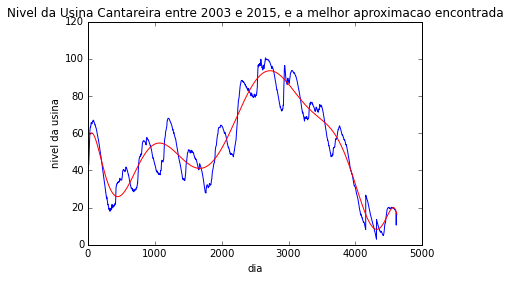

O residuo encontrado na aproximacao foi: 277508.984879


In [20]:
aprox19o = lambda x: np.sum([c19[j]*x**(19-j) for j in range(20)])
grau19Y = np.vectorize(aprox19o)(dia)

plt.plot(dia, niveis, 'b-')
plt.plot(dia, grau19Y , 'r-')
plt.title("Nivel da Usina Cantareira entre 2003 e 2015, e a melhor aproximacao encontrada")
plt.ylabel('nivel da usina')
plt.xlabel("dia")
plt.show()
print "O residuo encontrado na aproximacao foi:",residuoMMQ(aprox19o, dia, niveis)

## Análise da utilização do volume morto

Vamos explorar os dados a partir do ano de 2013:

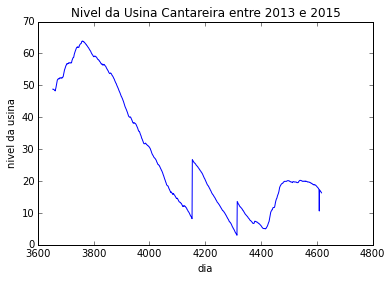

In [21]:
inicio = datas.index(20130101)

plt.plot(dia[inicio:], niveis[inicio:], 'b-')
plt.title("Nivel da Usina Cantareira entre 2013 e 2015")
plt.ylabel('nivel da usina')
plt.xlabel("dia")
plt.show()

Note que no ano de 2014 foi utilizada a maior cota de volume morto no sistema Cantareira. A seguir, vamos pegar os dados até antes do momento da utilização desse volume, e ajustaremos um polinômio de grau 4 a esse valor.

o volume morto foi utilizado apos 20140515


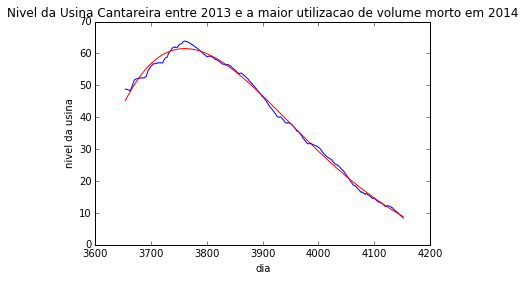

In [22]:
fim = inicio + np.argmin(niveis[inicio:4200])

print "o volume morto foi utilizado apos", datas[fim]

aprox = aproxGrauX(diaArray[inicio:fim], niveisArray[inicio:fim], grau=4)

aproxY = np.vectorize(aprox)(dia)

plt.plot(dia[inicio:fim], niveis[inicio:fim], 'b-')
plt.plot(dia[inicio:fim], aproxY[inicio:fim] , 'r-')
plt.title("Nivel da Usina Cantareira entre 2013 e a maior utilizacao de volume morto em 2014")
plt.ylabel('nivel da usina')
plt.xlabel("dia")
plt.show()

Verificaremos agora em quanto tempo a usina chegaria a 0% caso não fosse utilizada a cota de volume morto, de acordo com nossa aproximação:

In [23]:
indexDaSeca = np.argmin(np.absolute(aproxY))
print "Usina passaria de ", aproxY[indexDaSeca-1], "a", aproxY[indexDaSeca], "(chegaria a zero) no dia", \
datas[indexDaSeca], "se nao houvesse a primeira \nutilizacao de volume morto de 2014."

Usina passaria de  0.052764033433 a -0.04490519315 (chegaria a zero) no dia 20140815 se nao houvesse a primeira 
utilizacao de volume morto de 2014.


Agora, analisaremos quando a represa chegaria a 0% caso não fosse colocada a segunda cota de volume morto de 2014:

3.03064599393


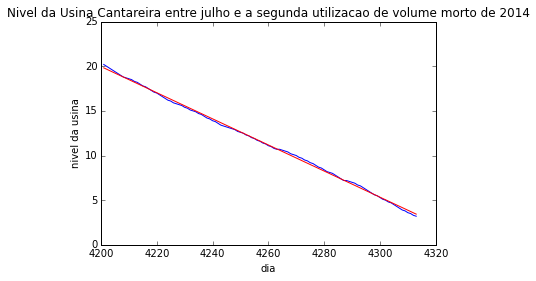

In [24]:
inicio2 = 4200
fim2 = inicio2 + np.argmin(niveis[4200:4400])

aproxLinear = aproxGrauX(diaArray[inicio2:fim2], niveisArray[inicio2:fim2], grau=2)
print residuoMMQ(aproxLinear, diaArray[inicio2:fim2], niveisArray[inicio2:fim2])

aproxLinearY = np.vectorize(aproxLinear)(dia)

plt.plot(dia[inicio2:fim2], niveis[inicio2:fim2], 'b-')
plt.plot(dia[inicio2:fim2], aproxLinearY[inicio2:fim2] , 'r-')
plt.title("Nivel da Usina Cantareira entre julho e a segunda utilizacao de volume morto de 2014")
plt.ylabel('nivel da usina')
plt.xlabel("dia")
plt.show()

In [25]:
indexDaSeca2 = np.argmin(np.absolute(aproxLinearY))
print "Usina passaria de ", aproxLinearY[indexDaSeca2-1], "a", aproxLinearY[indexDaSeca2], "(chegaria a zero) no dia",\
datas[indexDaSeca2], "se nao houvesse a segunda \nutilizacao de volume morto de 2014."

Usina passaria de  0.0745315374752 a -0.0715968974986 (chegaria a zero) no dia 20141115 se nao houvesse a segunda 
utilizacao de volume morto de 2014.


# Parte 2 - Equação de Calor

In [ ]:
import numpy as np

def funcBase (x)
    return = sin (πx) + x(1 − x)          #funcao base fixada

def diferencasAvancadas ( gamma, L, K, H)

    u = funcBase (0)                      # inicializa u(0)
    lmbda = gamma*K/(H**2)                # inicializa o lambda
    
    size = 1/(h**2)                       # inicializa tamanho, com L = 1
    
    contH = 0                             #
    contK = 0                             # inicializa os contadores e o vetor da primeira linha
    uVetX = []                            #
    
    u = ((1+(2*lmbda))*u) + 2*K           #
    uVetX.append(u)                       #
    contK++                               # esse bloco insire os dados pre-muliplicados na primeira linha da matriz,
    u = ((-1*lmbda)*u) + 2*K              # sem o primeiro "-lambda", alem de inserir zeros no resto da linha no for
    uVetX.append(u)                       #
    for cont in range(contH,size)         #
        uVetX.append(0)                   #
    contH++                               #
    
    while contH < size-1
    
        uVetX = []                        # Reinicia o vetor de linha
        for cont in range(0,contK)
            uVetX.append(0)
        
        u = ((-1*lmbda)*u) + 2*K          # Esse bloco faz todas as outras linhas da matriz, com os 3 valores da
        uVetX.append(u)                   # tridiagonal e preenchendo o resto da linha com zeros usando os for`s
        contK++                           #
        u = ((1+(2*lmbda))*u) + 2*K       #
        uVetX.append(u)                   #
        contK++                           #
        u = ((-1*lmbda)*u) + 2*K          #
        uVetX.append(u)                   #
        contK++                           #
                                          #
        for cont in range(contK,size)     #
            uVetX.append(0)               #
        
        contK -= 2                        # volta o contador para que esteja na posicao certa na proxima linha
        contH += H
    
    uVetX = []                            # Reinicia o vetor da linha
    for cont in range(contK,size)         #
        uVetX.append(0)                   #
    u = ((-1*lmbda)*u) + 2*K              # Esse bloco insere os zeros e os dados da ultima linha, sem o segundo "-lambda"
    uVetX.append(u)                       #
    contK++                               #
    u = ((1+(2*lmbda))*u) + 2*K           #
    uVetX.append(u)                       #